In [8]:
# 步骤
# 1.读取图片
# 2.裁剪出人脸
# 3.转为BLob格式
# 4.处理所有图片
# 5.存储为numpy 文件

In [9]:
# 导入相关包
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 读取图片

In [16]:
# 读取图片
img = cv2.imread(r'.\images\mask_cor\00000_Mask.jpg')
img.shape

AttributeError: 'NoneType' object has no attribute 'shape'

In [7]:
# 显示图片
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


## 裁剪人脸

In [2]:
#加载SSD模型
face_detector = cv2.dnn.readNetFromCaffe('./weights/deploy.prototxt.txt','weights/res10_300x300_ssd_iter_140000.caffemodel')
face_detector

NameError: name 'cv2' is not defined

In [6]:
# 转为Blob
# 对图像进行预处理，包括减均值，比例缩放，裁剪，交换通道等，返回一个4通道的blob
img_blob = cv2.dnn.blobFromImage(img,1,(1024,1024),(104,177,123),swapRB=True)
img_blob.shape

(1, 3, 1024, 1024)

In [7]:
# 输入
face_detector.setInput(img_blob)

In [8]:
# 推理
detections = face_detector.forward()

In [12]:
detections.shape

(1, 1, 200, 7)

In [10]:
# 人数
person_count = detections.shape[2]

In [46]:
person_count

200

In [32]:
# 人脸检测函数
def face_detect(img):
    #转为Blob
    img_blob = cv2.dnn.blobFromImage(img,1,(300,300),(104,177,123),swapRB=True)
    # 输入
    face_detector.setInput(img_blob)
    # 推理
    detections = face_detector.forward()
    # 获取原图尺寸
    img_h,img_w = img.shape[:2]
    
    # 人脸数量
    person_count = detections.shape[2]

    for face_index in range(person_count):
        # 置信度
        confidence = detections[0,0,face_index,2]
        if confidence > 0.5:
            locations = detections[0,0,face_index,3:7] * np.array([img_w,img_h,img_w,img_h])
            # 取证
            l,t,r,b = locations.astype('int')
            # cv2.rectangle(img,(l,t),(r,b),(0,255,0),5)
            return img[t:b,l:r]
    return None

In [33]:
# 测试图片
img_new = cv2.imread(r'.\images\mask_cor\00000_Mask.jpg')

In [34]:
face_crop = face_detect(img_new)

In [16]:
face_crop.shape

(699, 635, 3)

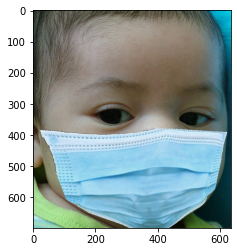

In [57]:
# 显示图片
plt.imshow(cv2.cvtColor(face_crop,cv2.COLOR_BGR2RGB))

## 3.转为Blob图像

In [35]:
# 转为Blob的函数
def imgBlob(img):
    # 转为Blob
    img_blob = cv2.dnn.blobFromImage(img,1,(100,100),(104,177,123),swapRB=True)
    # 压缩维度
    img_squeeze = np.squeeze(img_blob).T
    # 旋转
    img_rotate = cv2.rotate(img_squeeze,cv2.ROTATE_90_CLOCKWISE)
    # 镜像
    img_flip =  cv2.flip(img_rotate,1)
    # 去除负数，并归一化
    img_blob = np.maximum(img_flip,0) / img_flip.max()
    return img_blob

In [38]:
from skimage.feature import hog
img_test = cv2.imread(r'.\images\mask_cor\00000_Mask.jpg')
img_g = cv2.cvtColor(img_test,cv2.COLOR_BGR2GRAY)
img_g.shape
fd = hog(img_g, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1))
fd.shape


C:\Users\haitao\Anaconda3\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


(32768,)

## 处理所有图片

In [23]:
# 获取图片类别 labels

In [36]:
import os,glob
import tqdm

In [37]:
labels = os.listdir('images/')
labels

['mask_cor', 'mask_uncor', 'no_mask']

In [26]:
# 遍历所有类别

# 两个列表保存结果
img_list1 = []
label_list1 = []
for label in labels:
    # 获取每类文件列表
    file_list =glob.glob('images/%s/*.jpg' % (label))
    
    for img_file in tqdm.tqdm( file_list ,desc = "处理 %s "  % (label)):
        # 读取文件
        img = cv2.imread(img_file)
        # 裁剪人脸
        img_crop = face_detect(img)
        # 判断空的情况
        if img_crop is not None:
            # 转为Blob
            img_blob = imgBlob(img_crop)
            img_blobg = cv2.cvtColor(img_blob,cv2.COLOR_BGR2GRAY)
            fd = hog(img_blobg, orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(1, 1))
            img_list1.append(fd)
            label_list1.append(label)
    

处理 no_mask : 100%|█████████████████████████████████████████████████████████████████| 1000/1000 [00:50<00:00, 19.93it/s]


## 5.保存为numpy文件

In [27]:
# 转为numpy数据
X_g = np.asarray(img_list1)
Y_g = np.asarray(label_list1)

In [39]:
X_g.shape,Y_g.shape

((2861, 1152), (2861,))

In [146]:
# 存储为numpy文件
np.savez('./data/imageData_g.npz',X_g,Y_g)

In [40]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

x_train,x_test,y_train,y_test  = train_test_split(X_g,Y_g,
                                                  test_size=0.25,random_state=42)

cls = svm.SVC(kernel='rbf')
cls.fit(x_train,y_train)
predictLabels = cls.predict(x_test)

print ( "svm acc:%s" % accuracy_score(y_test,predictLabels))

cls1 = svm.SVC(kernel='linear')
cls1.fit(x_train,y_train)
predictLabels = cls1.predict(x_test)

print ( "svm 1 acc:%s" % accuracy_score(y_test,predictLabels))


cls2 = svm.SVC(kernel='poly')
cls2.fit(x_train,y_train)
predictLabels = cls2.predict(x_test)

print ( "svm  2 acc:%s" % accuracy_score(y_test,predictLabels))

svm acc:0.9413407821229051
svm 1 acc:0.9287709497206704
svm  2 acc:0.9567039106145251


In [145]:
from joblib import dump, load
dump(cls, './models/svc.joblib') 

['./models/svc.joblib']

In [134]:
# 调用模型
cls = load('./models/svc.joblib') 
predictLabels = cls.predict(x_test)

print ( "svm acc:%s" % accuracy_score(y_test,predictLabels))

svm acc:0.9427374301675978


In [31]:
predictLabels[0]

'mask_uncor'